In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
from tqdm import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random
# import png

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4984788027876810977
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9792466944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5989846677400897553
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13042235019359673931
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
#miceList.remove('1253')
#miceList.remove('1231')
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

In [9]:
miceList = getMiceList(Files[0])
miceList.remove('1253')
miceList.remove('1231')
mOrder = np.random.permutation(len(miceList))

mTrain = ['1231', '1253']
mValidate =[miceList[i] for i in mOrder[:2]]
mTest =  [miceList[i] for i in mOrder[2:4]]
mTrain = mTrain+ [miceList[i] for i in mOrder[4:]]

print(mTrain,mValidate,mTest)
# print(miceList[mOrder[:2]])

['1231', '1253', '2976', '2980', '0761', '7584', '8815', '1208', '4539', '8430', '1236', '8803'] ['7909', '1222'] ['2981', '1793']


In [9]:
# create and save the LFP images so can do flow from directory
savePath = "E:\\data\\"
for g in ['Train','Validate','Test']:
    if not os.path.isdir(savePath+g):
            os.mkdir(savePath+g)
    sPath = savePath+g+"\\"
    if g=='Test':
        os.mkdir(sPath+'unlabeled')
    else:
        for cond in ['Healthy','Acute','Chronic']:
            if not os.path.isdir(sPath+cond):
                os.mkdir(sPath+cond)


In [23]:
# add speed data:
from matplotlib import image as pltI
savePath = "E:\\data\\"
dtL = 0.0032768
tPlot = np.linspace(-8,8,int(16/dtL-1))
f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
for g in ['Test','Validate','Train']: #'Train','Validate',
    mList = eval("m"+g)
    sPath = savePath+g+"\\"
    for m in tqdm(mList):
        data =  getData(Files[0],['lfp'],period ='Pre', mice=m)
        for sess in data:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            speed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            caT = np.arange(max(speed.shape))*0.05
            speedF = sci.interpolate.interp1d(caT, speed,kind='linear')

            period = periodCalc(day)
            freq = f[m][sess]['Pre']['freq'][:]
            coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff = coeff[:,(lfpOutliers[:,0]==0)]
            coeff = coeff.T*freq
            Hs = np.nansum(coeff, axis=1)
            coeff = coeff.T/Hs.T
            coeff = coeff.T
            a = sci.signal.decimate(coeff,10,axis=0)

            lfpT = np.arange(max(a.shape))*dtL
            if max(caT)< max(lfpT):
                endInd = np.argmin(np.abs(max(caT)-lfpT))
                print(endInd)
                while lfpT[endInd]>max(caT):
                    endInd = endInd-1
            speedNew = speedF(lfpT[:endInd])
            speedNew =speedNew.reshape((len(speedNew),1))/5
            a = np.hstack((a[:endInd,:],speedNew))

            del coeff
            A = [a[i : i + tPlot.shape[0],:] for i in range(0, a.shape[0],int(np.ceil(2/dtL)))] 
            if g == 'Test':
                sPathSess = sPath + 'unlabeled\\'
            else:
                sPathSess = sPath +period+'\\'
            for ind,img in enumerate(A):
                z = (65535*((img - np.nanmin(img))/( np.nanmax(img)- np.nanmin(img)))).astype(np.uint16)
                pltI.imsave(sPathSess+'{m:s}_{p:s}_{ind:d}.png'.format(m=sess,p=period,ind=ind), z)
                

                

                


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

cleaning up lfp data
181549
181564
181549
181549
181564
181564
found  50.0  outlier points
181564
181549
181564
181549
144867
181564
181564


 50%|█████████████████████████████████████████▌                                         | 1/2 [14:55<14:55, 895.38s/it]

cleaning up lfp data
181549
181549
181549
181549
181549
181564
181564
181564
181549
181564
181564
181564
181564
181534


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

cleaning up lfp data
181549
181549
181549
181549
181549
181564
181549
181549
181549
181564
181549
181564
181549
181549


 50%|█████████████████████████████████████████                                         | 1/2 [18:34<18:34, 1114.28s/it]

cleaning up lfp data
181564
181564
181549
181564
181549
181549
181549
181549
181564
181549
181564
181549
181564
181564


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

cleaning up lfp data
181549
181564
181564


  8%|██████▊                                                                           | 1/12 [03:19<36:31, 199.26s/it]

cleaning up lfp data
181549
181549
181549


 17%|█████████████▋                                                                    | 2/12 [06:27<32:09, 192.93s/it]

cleaning up lfp data
181549
181549
181564
181564
found  29.0  outlier points
181564
181549
181564
181564
181564
181549
181534
181549
181549
181564
181549
181549
181549
181549
181564


 25%|████████████████████                                                            | 3/12 [27:25<1:41:50, 678.97s/it]

cleaning up lfp data
181549
181549
181549
181534
181549
181564
181564
181564
181549
181549
181564
181564
181549
181564
181564
181549
181549
181564
181564


 33%|██████████████████████████▋                                                     | 4/12 [51:05<2:09:32, 971.54s/it]

cleaning up lfp data
181549
181549
181549
181549
181564
181564
181564
181549
181549
181564
181549
181549
178116
181549


 42%|████████████████████████████████                                             | 5/12 [1:09:23<1:58:39, 1017.13s/it]

cleaning up lfp data
181564
181564
181549
181549
181564
181549
181549
181549
181564
181549
181549
181549
181549
181534
181549
181564
181549


 50%|██████████████████████████████████████▌                                      | 6/12 [1:28:36<1:46:21, 1063.61s/it]

cleaning up lfp data
181549
181549
181564
181564
181549
181549
181549
181564
181549
181564
181549
181564
181564


 58%|█████████████████████████████████████████████▌                                | 7/12 [1:41:59<1:21:30, 978.18s/it]

cleaning up lfp data
181549
181564
181549
181564
181549
181564
181549
181549
181564
181564
181549
181564
181564
181564


 67%|████████████████████████████████████████████████████                          | 8/12 [1:58:25<1:05:23, 980.88s/it]

cleaning up lfp data
I deleted session: 1208_day12
181549
181564
181549
181549
181549
181549
found  17.0  outlier points
181564
181534
181549
181549
181564
181564
181564


 75%|████████████████████████████████████████████████████████████                    | 9/12 [2:12:48<47:12, 944.03s/it]

cleaning up lfp data
I deleted session: 2976_day4
found  1.0  outlier points
181564
181564
181549
181549
181549
181564
181549
181564
181549
181549
181549
181564
found  3.0  outlier points
181549


 83%|█████████████████████████████████████████████████████████████████▊             | 10/12 [2:26:40<30:18, 909.30s/it]

cleaning up lfp data
found  1.0  outlier points
181549
181564
181549
181549
181549
181534
181564
181564
181534
found  888231.0  outlier points
found  481139.0  outlier points
181549
181549
181549


 92%|████████████████████████████████████████████████████████████████████████▍      | 11/12 [2:40:47<14:50, 890.29s/it]

cleaning up lfp data
181549
181549
181549
161240
181549
181534
181549
181549
181564
181564
181564
181564
163162
181564


100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [2:55:53<00:00, 879.44s/it]


[0.00000000e+00 1.28000001e-05 1.79200000e-04 ... 1.99910400e-01
 1.99948800e-01 2.00000000e-01]


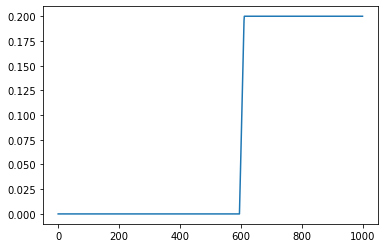

In [21]:
# speedNew = speedF(lfpT[:endInd])
# speedNew =speedNew.reshape((len(speedNew),1))/5
# a = np.hstack((a[:endInd,:],speedNew))
print(np.unique(speedNew))
plt.plot(speedNew[:1000])

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)#(rescale = 1./65535)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)#(rescale = 1./65535)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)#(rescale = 1./65535) #rescale=1./255
train_generator = train_datagen.flow_from_directory(
    directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
    target_size=(600, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=36
)
validate_generator = valid_datagen.flow_from_directory(
    directory="E:\\data\\Validate\\",#'E:\\data\\imageTest\\test_set\\',#
    target_size=(600, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory="E:\\data\\Test\\",#'E:\\data\\imageTest\\test_set\\',#
    target_size=(600, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode=None,
    shuffle=False
)



Found 23329 images belonging to 2 classes.
Found 4470 images belonging to 2 classes.
Found 4768 images belonging to 1 classes.


In [6]:
# calculate the class weight: - flow from directory goes alphabetically so Acute, Chroniq, Healthy
files_per_class = []
for folder in ['Chronic','Healthy']:
    if not os.path.isfile("E:\\data\\Train\\"+folder):
            files_per_class.append(len(os.listdir("E:\\data\\Train\\"+folder)))
total_files = sum(files_per_class)
class_weights = {}
print(files_per_class)
for i in range(len(files_per_class)):
    class_weights[i] = (1 /(float(files_per_class[i]))) *( total_files/2)

print(class_weights)

[12601, 10728]
{0: 0.9256805015474963, 1: 1.0872949291573453}


(32, 600, 300, 1)
0.11764707 0.8431373


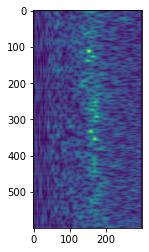

In [7]:
a = test_generator.next()
plt.imshow(a[4,:,:,0])
print(a.shape)
print(np.min(a[:,:,:,0]),np.max(a[:,:,:,0]))

In [21]:
del model

In [22]:
# model for v4
# mix_layer = []
# inputShape = (600,300,1)
# inp = Input(shape=inputShape)
# convs = []
# kernel_size= {}
# kernel_size[0]= (20,5)
# kernel_size[1]= (5,15)
# for k_no in range(len(kernel_size)):
#     conv = Conv2D(16, kernel_size[k_no],activation='relu',
#                   padding='SAME',input_shape=inputShape)(inp)
#     pool = MaxPooling2D(pool_size=(2,2))(conv)
#     mix_layer.append(pool)
# out = Concatenate()(mix_layer)
# conv_model = Model(inputs=inp, outputs=out)

model = Sequential()
# model.add(conv_model) 
model.add(Conv2D(8, kernel_size=(15,15), activation='relu', input_shape=(600,300,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.50))
model.add(Conv2D(16, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Dropout(0.50))


# model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))#,kernel_initializer=initializer))
model.add(Flatten())
# model.add(Dense(50, activation='relu'))#,kernel_initializer=initializer))
model.add(Dense(2, activation='sigmoid'))

In [23]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 586, 286, 8)       1808      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 293, 143, 8)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 293, 143, 8)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 289, 139, 16)      3216      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 72, 34, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 72, 34, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 39168)            

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=160,
    mode='max',
    restore_best_weights=True)

In [24]:
modelName = 'LFP_period_v16'

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

stepTrain=train_generator.n//train_generator.batch_size
stepValidate=validate_generator.n//validate_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=stepTrain,
                    validation_data=validate_generator,
                    validation_steps=stepValidate,
                    epochs=500,class_weight=class_weights,callbacks=[early_stopping])#,


Epoch 1/500
729/729 [==============================] - 501s 687ms/step - loss: 0.6967 - accuracy: 0.4963 - val_loss: 0.6946 - val_accuracy: 0.4000
Epoch 2/500
729/729 [==============================] - 252s 345ms/step - loss: 0.6932 - accuracy: 0.4860 - val_loss: 0.6948 - val_accuracy: 0.4004
Epoch 3/500
729/729 [==============================] - 251s 344ms/step - loss: 0.6932 - accuracy: 0.4826 - val_loss: 0.6919 - val_accuracy: 0.6000
Epoch 4/500
729/729 [==============================] - 248s 340ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6921 - val_accuracy: 0.6000
Epoch 5/500
729/729 [==============================] - 250s 343ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6908 - val_accuracy: 0.5996
Epoch 6/500
729/729 [==============================] - 251s 345ms/step - loss: 0.6932 - accuracy: 0.5126 - val_loss: 0.6927 - val_accuracy: 0.5989
Epoch 7/500
729/729 [==============================] - 254s 348ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0

729/729 [==============================] - 250s 344ms/step - loss: 0.4914 - accuracy: 0.7548 - val_loss: 0.7861 - val_accuracy: 0.5130
Epoch 112/500
729/729 [==============================] - 250s 343ms/step - loss: 0.4874 - accuracy: 0.7540 - val_loss: 0.8855 - val_accuracy: 0.5045
Epoch 113/500
729/729 [==============================] - 250s 343ms/step - loss: 0.4933 - accuracy: 0.7525 - val_loss: 0.8365 - val_accuracy: 0.5133
Epoch 114/500
729/729 [==============================] - 249s 342ms/step - loss: 0.4916 - accuracy: 0.7531 - val_loss: 0.8226 - val_accuracy: 0.4915
Epoch 115/500
729/729 [==============================] - 249s 341ms/step - loss: 0.4880 - accuracy: 0.7552 - val_loss: 0.8580 - val_accuracy: 0.4890
Epoch 116/500
729/729 [==============================] - 250s 343ms/step - loss: 0.4866 - accuracy: 0.7535 - val_loss: 0.8752 - val_accuracy: 0.5047
Epoch 117/500
729/729 [==============================] - 250s 343ms/step - loss: 0.4824 - accuracy: 0.7581 - val_loss: 0

729/729 [==============================] - 253s 346ms/step - loss: 0.4642 - accuracy: 0.7730 - val_loss: 0.9224 - val_accuracy: 0.5031
Epoch 167/500
729/729 [==============================] - 249s 342ms/step - loss: 0.4668 - accuracy: 0.7701 - val_loss: 0.8623 - val_accuracy: 0.5137
Epoch 168/500
729/729 [==============================] - 250s 343ms/step - loss: 0.4649 - accuracy: 0.7704 - val_loss: 0.9058 - val_accuracy: 0.4946
Epoch 169/500
729/729 [==============================] - 250s 342ms/step - loss: 0.4707 - accuracy: 0.7674 - val_loss: 0.8277 - val_accuracy: 0.5207
Epoch 170/500
729/729 [==============================] - 250s 343ms/step - loss: 0.4661 - accuracy: 0.7681 - val_loss: 0.8967 - val_accuracy: 0.5031
Epoch 171/500
729/729 [==============================] - 251s 344ms/step - loss: 0.4663 - accuracy: 0.7686 - val_loss: 0.8602 - val_accuracy: 0.5088
Epoch 172/500
729/729 [==============================] - 249s 342ms/step - loss: 0.4675 - accuracy: 0.7677 - val_loss: 0

In [31]:
## Saving the model
##
model.save('E:\\'+modelName)
model.save_weights('E:\\'+modelName+'_weights.h5')

INFO:tensorflow:Assets written to: E:\LFP_period_v13\assets


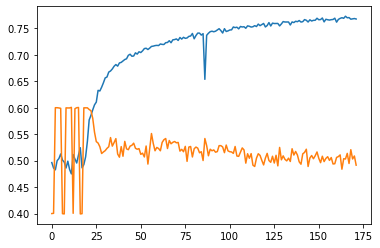

In [25]:
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])# history.history

In [13]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

labels = (train_generator.class_indices)
pred = model.predict_generator(test_generator,verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for f in test_generator.filenames:
    sess = f.split("_")[1]
    if sess[0] == 'B':
        day = 0
    else:
        day = int(re.findall(r'\d+',sess)[0])

    # get data
    period = periodCalc(day) 
    y.append(labels[period])

C:\Users\dzemel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


261/261 [==============================] - 156s 598ms/step
[0 1 2]


0.438758389261745


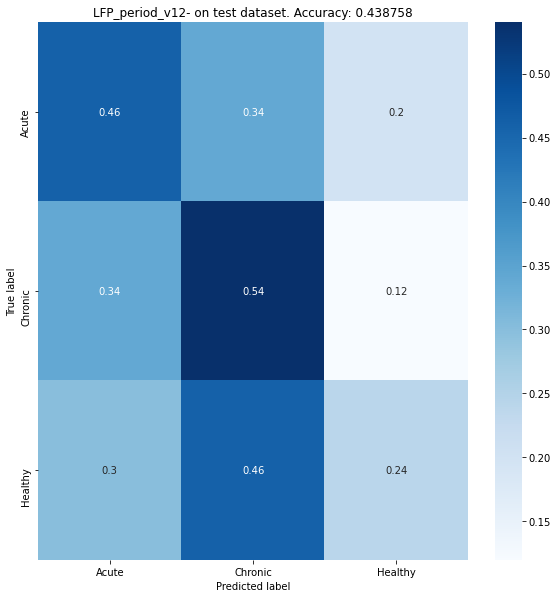

In [14]:
classes=labels.keys()
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on test dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Test.png")
print(np.sum(y==pred)/len(y))

In [71]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# train_datagenT = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# train_generatorT = train_datagenT.flow_from_directory(
#     directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
#     target_size=(300, 300),
#     color_mode="grayscale",
#     batch_size=32,
#     class_mode="categorical",
#     shuffle=False,
#     seed=36
# )


labels = (train_generator.class_indices)
pred = model.predict_generator(train_generatorT,verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for f in train_generatorT.filenames:
    sess = f.split("_")[1]
    if sess[0] == 'B':
        day = 0
    else:
        day = int(re.findall(r'\d+',sess)[0])

    # get data
    period = periodCalc(day) 
    y.append(labels[period])

567/567 [==============================] - 89s 157ms/step
[0 1 2]


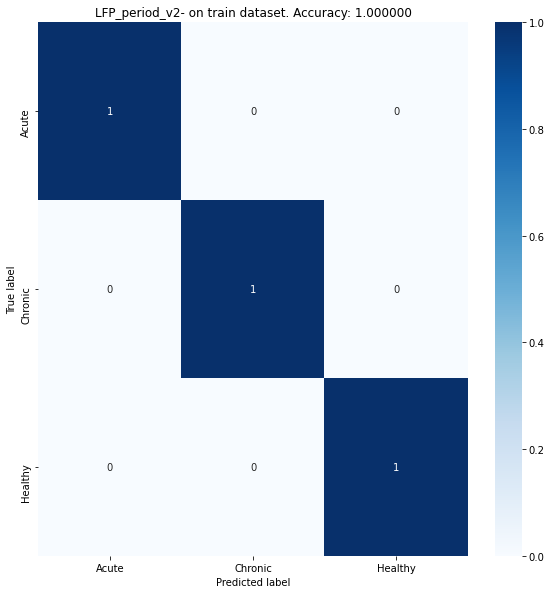

In [73]:
classes=labels.keys()
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on train dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Train.png")


In [61]:
score = model.evaluate(train_generatorT)
print(score)

567/567 [==============================] - 89s 157ms/step - loss: 3.5345e-04 - accuracy: 1.0000
[0.00035344576463103294, 1.0]


In [56]:
pred = model.predict_generator(train_generator,verbose=1)
pred.shape

567/567 [==============================] - 89s 157ms/step


(18130, 3)

In [57]:
train_generatorT = train_datagen.flow_from_directory(
    directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
    target_size=(300, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=36
)


array([[9.9993336e-01, 6.6623645e-05, 2.0047966e-09],
       [1.0000000e+00, 1.3673330e-08, 4.0443326e-10],
       [3.7493074e-08, 1.0000000e+00, 1.9402356e-11],
       [3.0466440e-04, 9.9913293e-01, 5.6242698e-04]], dtype=float32)

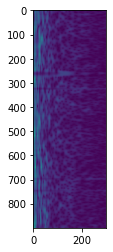

In [85]:
%matplotlib inline
for d,l in train_generator:
    plt.imshow(d[16,:,:,0])
    break